#Librerias

In [1]:
!pip install opencv-python # instala la librería OpenCV para procesamiento de imágenes

In [2]:
# Librerías del sistema y manejo de archivos
import os
import sys
from os import listdir
from os.path import join

# Librerías para uso en Google Colab
from google.colab import drive

# Librerías para procesamiento numérico y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Librerías para procesamiento y lectura de imágenes
import cv2

# Librerías para machine learning
from sklearn.model_selection import train_test_split
from sklearn import tree, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier

# Librerías para deep learning
import tensorflow as tf

# Librerías para utilidades adicionales
from tqdm import tqdm  # barra de progreso
import joblib  # para guardar/cargar objetos como modelos o arrays

# Conectar con google drive

In [3]:
# conectar con Google Drive para acceder a archivos desde Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

In [5]:
import _funciones as fn #Llamar el archivo de funciones de este proyecto

# Selección de métrica o indicador para evaluación de modelos

## **Sabemos que existen los siguientes indicadores que pueden servir para el contexto de este análisis**

- **Precision:** Tasa de acierto en los positivos predichos (¿qué porcentaje de las imágenes clasificadas como cáncer de piel realmente lo eran?). Un valor alto indica que el modelo comete pocos falsos positivos, lo cual es importante para evitar alarmar o tratar innecesariamente a pacientes sanos.

- **Recall (Sensibilidad):** Tasa de detección de positivos (de todas las imágenes que realmente eran cáncer de piel, ¿cuántas fueron correctamente identificadas por el modelo?). Fundamental cuando se desea minimizar los falsos negativos, es decir, evitar pasar por alto un caso real de cáncer.

- **F1_Score:** Media armónica entre Precision y Recall. Es útil cuando se busca un equilibrio entre no perder casos positivos (Recall) y no clasificar en exceso como positivos (Precision). Ideal cuando hay desbalance entre clases, como en conjuntos con pocos casos de cáncer comparados con lesiones benignas.

- **Accuracy:** Porcentaje total de imágenes correctamente clasificadas (tanto benignas como malignas). Aunque es fácil de interpretar, puede ser **engañoso en problemas desbalanceados** como el cáncer de piel (por ejemplo, si solo el 5% son malignas, un modelo que siempre predice "benigno" tendría 95% de accuracy pero no detectaría ningún caso real de cáncer).

- **AUC (Área bajo la curva ROC):** Evalúa la capacidad del modelo para distinguir entre clases (lesiones malignas vs. benignas). Mide la tasa de verdaderos positivos frente a la de falsos positivos en todos los umbrales posibles. A mayor AUC, mejor es el modelo para **discriminar entre cáncer y no cáncer**, independientemente del umbral de decisión usado.

- **Especificidad (Specificity):** Proporción de negativos correctamente identificados (de todas las imágenes benignas, ¿cuántas fueron correctamente clasificadas como no cáncer?). Es el complemento del Recall. Útil cuando se desea reducir los falsos positivos, por ejemplo, para no derivar innecesariamente a muchos pacientes sanos a exámenes adicionales.

- **Log Loss (Pérdida Logarítmica):** Mide la incertidumbre del modelo en sus predicciones de probabilidad. Penaliza más los errores de clasificación con alta confianza. Útil para modelos probabilísticos que devuelven una probabilidad de malignidad, no solo una clase binaria.

- **Balanced Accuracy:** Promedio entre Sensibilidad y Especificidad. Útil cuando las clases están desbalanceadas, ya que equilibra la atención entre detectar bien los casos de cáncer y evitar falsas alarmas.



## **Análisis del problema y eleccion de métrica más adecuada**
En este caso, estamos clasificando imágenes de lesiones en la piel para identificar casos de cáncer de piel. Nos interesa especialmente detectar correctamente los casos positivos (cáncer), ya que omitir uno de estos casos (falsos negativos) puede tener consecuencias muy graves para la salud del paciente.

Por eso, el **Recall** es crítico, ya que queremos minimizar el número de cánceres no detectados. Sin embargo, enfocarnos únicamente en Recall puede hacer que el modelo clasifique excesivamente como "cáncer", aumentando los falsos positivos (lo cual en la vida real implicaria biopsias innecesarias, papelos inncesarios, estrés para el paciente, etc.)

Para equilibrar la capacidad de detección de cáncer con la tasa de falsos positivos, el mejor indicador en este contexto es el **AUC**. Este mide la capacidad del modelo para diferenciar entre lesiones benignas y malignas a través de todos los posibles umbrales de clasificación. Un alto AUC significa que el modelo puede distinguir bien entre ambas clases, maximizando de esta forma la detección de cáncer sin comprometer demasiado la clasificación de los casos benignos.

En conclusión, se elige el AUC como indicador principal, ya que mide la capacidad del modelo para diferenciar entre cáncer y no cáncer, incluso con clases desbalanceadas. También se considerará el Recall como indicador secundario, para asegurar que los casos de cáncer sean detectados correctamente y evaluar en los modelos que sea posible si ambos indicadores pueden ofrecer buenos resultados simultáneamente.


# Carga de datos procesados

array([[[228, 176, 163],
        [228, 176, 163],
        [229, 177, 164],
        ...,
        [231, 173, 172],
        [229, 173, 172],
        [230, 177, 173]],

       [[227, 175, 162],
        [222, 170, 157],
        [226, 174, 161],
        ...,
        [228, 170, 169],
        [228, 172, 171],
        [225, 172, 168]],

       [[225, 173, 159],
        [223, 171, 158],
        [226, 174, 161],
        ...,
        [226, 170, 169],
        [231, 177, 173],
        [226, 173, 169]],

       ...,

       [[140,  70,  61],
        [150,  78,  66],
        [156,  84,  69],
        ...,
        [215, 176, 155],
        [208, 170, 151],
        [212, 175, 156]],

       [[138,  70,  58],
        [153,  83,  68],
        [163,  91,  76],
        ...,
        [215, 179, 157],
        [213, 177, 154],
        [213, 178, 156]],

       [[149,  83,  70],
        [157,  89,  73],
        [165,  92,  75],
        ...,
        [212, 176, 152],
        [214, 178, 157],
        [212, 177, 155]]], dtype=uint8)
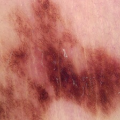

In [6]:
# Cargar los conjuntos de entrenamiento y prueba ya procesados

x_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_test.pkl')

x_train[0] # Muestra la primera imagen del conjunto de entrenamiento

## Preprocesamiento de datos

In [7]:
# Convertir a tipo float para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [8]:
# Escalar valores entre 0 y 1 con base en el valor máximo
x_train /= 255
x_test  /= 255

In [9]:
#Visualizar forma de las imagenes para luego convertir a 1D
print(x_train.shape)
print(x_test.shape)

(2637, 120, 120, 3)
(568, 120, 120, 3)


In [10]:
 # Convertir imágenes en vectores 1D de tamaño 43200
x_train2=x_train.reshape(2637,43200) # para convertilos en (120,120,3)
x_test2=x_test.reshape(660, 43200)

print(x_train2.shape) # Mostrar forma del arreglo de entrenamiento
print(x_test2.shape) # Mostrar forma del arreglo de prueba

x_train2[1]

ValueError: cannot reshape array of size 24537600 into shape (660,43200)

# Entrenamiento y evaluación de modelos tradicionales en el análisis del cancer de piel

## Modelo 1: Bosques Aleatorios

In [ ]:
rf = RandomForestClassifier() # Modelo de bosques aleatorios
rf.fit(x_train2, y_train) # Entrenar el modelo con los datos de entrenamiento
pred_test = rf.predict(x_test2) # Predecir las clases (benigno o maligno) con los datos de pruebas

In [ ]:
auc_rf = metrics.roc_auc_score(y_test, pred_test) # Calcular AUC para bosques aleatorios
recall_rf = metrics.recall_score(y_test, pred_test) # Calcular recall para bosques aleatorios

# Imprimir metricas metricas
print("Random Forest - AUC:", auc_rf)
print("Random Forest - Recall:", recall_rf)

## Modelo 2: Árbol de Decisión

In [ ]:
clf_dt = tree.DecisionTreeClassifier() # Modelo de arbol de decision
clf_dt.fit(x_train2, y_train) # Entrenar el modelo con los datos de entrenamiento
pred_test = clf_dt.predict(x_test2) # Predecir las clases (benigno o maligno) con los datos de pruebas

In [ ]:
auc_dt = metrics.roc_auc_score(y_test, pred_test) # Calcular AUC para arbol de decision
recall_dt = metrics.recall_score(y_test, pred_test) # Calcular recall para arbol de decision

# Imprimir metricas metricas
print("Decision Tree - AUC:", auc_dt)
print("Decision Tree - Recall:", recall_dt)

## Modelo 3: K-Vecinos más cercanos

In [ ]:
knn = KNeighborsClassifier() # Modelo de vecinos mas cercanos
knn.fit(x_train2, y_train) # Entrenar el modelo con los datos de entrenamiento
pred_test = knn.predict(x_test2) # Predecir las clases (benigno o maligno) con los datos de pruebas

In [ ]:
auc_knn = metrics.roc_auc_score(y_test, pred_test) # Calcular AUC para vecinos mas cercanos
recall_knn = metrics.recall_score(y_test, pred_test) # Calcular recall para vecinos mas cercanos

# Imprimir metricas metricas
print("KNN - AUC:", auc_knn )
print("KNN - Recall:", recall_knn)

## Modelo 4: Regresión logística

In [ ]:
logreg = LogisticRegression(max_iter=500) # modelo de regresión logística con 500 iteraciones
logreg.fit(x_train2, y_train) # Entrenar el modelo con los datos de entrenamiento
pred_test = logreg.predict(x_test2) # Predecir las clases (benigno o maligno) con los datos de pruebas

In [ ]:
auc_lr = metrics.roc_auc_score(y_test, pred_test) # Calcular AUC para regresión logística
recall_lr = metrics.recall_score(y_test, pred_test) #Calcular recall para regresión logística

# Imprimir metricas metricas
print("Logistic Regression - AUC:", auc_lr)
print("Logistic Regression - Recall:", recall_lr)

## Modelo 5: Red neuronal simple

In [ ]:
 # Crear modelo secuencial (capas apiladas)
fc_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]), #Aplanar entrada
    tf.keras.layers.Dense(128, activation='relu'), # Capa densa con 128 neuronas y ReLU
    tf.keras.layers.Dense(64, activation='relu'), # Capa densa con 64 neuronas y ReLU
    tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida (1 neurona), activación sigmoide para clasificación binaria
])

# Optimizador y funcion de perdida para el modelo
fc_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC', 'Recall', 'Precision'] #Metricas a evaluar
)

# entrenar el modelo con validacion
fc_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

In [ ]:
#Metricas de evaluacion de la red neuronal simple
test_loss, test_acc, test_auc, test_recall, test_precision = fc_model.evaluate(x_test, y_test, verbose=2)

# Mostrar metricas
print("\n### Resultados Red Neuronal ###")
print("Test Accuracy:", test_acc)
print("Test AUC:", test_auc)
print("Test Recall:", test_recall)
print("Test Precision:", test_precision)

In [ ]:
pred_test = (fc_model.predict(x_test) > 0.50).astype('int') # Predecir y aplicar umbral de 0.5 para convertir a clase 0 o 1
cm = metrics.confusion_matrix(y_test, pred_test, labels=[1, 0])  # Calcular matriz de confusión
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['Cáncer', 'Benigno']) # para visualizacion de matriz de confusion
disp.plot()

print(metrics.classification_report(y_test, pred_test)) # reporte con precisión, recall y f1-score

#fc_model.save('salidas/model.keras') #Guardar modelo entrenado en caso de ser necesario

# Resumen de indicadores

In [ ]:
# Crear DataFrame con los resultados
resultados = pd.DataFrame({
    "Modelo": ["Random Forest", "Árbol de Decisión", "KNN", "Regresión Logística", "Red Neuronal"], # Nombres de los modelos
    "AUC": [auc_rf, auc_dt, auc_knn, auc_lr, test_auc], # metricas auc de todos los modelos
    "Recall": [recall_rf, recall_dt, recall_knn, recall_lr, test_recall] #metricas recall de todos los modelos
})

# Mostrar la tabla ordenada por AUC de mayor a menor
resultados = resultados.sort_values(by="AUC", ascending=False)

# Mostrar tabla sin índice
print(tabulate(resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

En la tabla se presentan los resultados de varios modelos de clasificación evaluados con dos métricas clave: AUC (Área bajo la curva ROC) y Recall. El AUC mide la capacidad del modelo para distinguir entre clases, siendo valores cercanos a 1 indicativos de un buen desempeño general. En este caso, el Random Forest obtuvo el AUC más alto (0.8336), mostrando un excelente balance entre sensibilidad y especificidad. Por otro lado, el Recall indica qué tan bien el modelo identifica correctamente los casos positivos. Aquí, el modelo KNN alcanzó el mejor recall (0.8907), lo que significa que detecta la mayor parte de los positivos, aunque su AUC es más bajo (0.7453), lo que sugiere una menor capacidad de discriminación global. La Regresión Logística, aunque tiene el AUC más bajo (0.7753), también muestra un recall alto (0.8453), lo cual puede ser útil si se prioriza la detección de positivos, como en problemas médicos o de fraude. En conjunto, los resultados evidencian una compensación entre ambas métricas, y la elección del modelo más adecuado dependerá de si se prioriza una detección amplia de positivos (alto recall) o una capacidad global de discriminación (alto AUC).